In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

data = pd.read_csv("mc_data.csv")

def graph(strategy, metric):
    """
    Graph a 3d plot with X: stations, Y: ambulances, Z: metric
    Metric: "completion_time", "outstanding_req", "idle_ambulances"
    """
    # Grab data for the selected strategy
    strat_selector = data["strategy"] == strategy
    strat_data = data[strat_selector]

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(strat_data["stations"], strat_data["total_ambulances"], strat_data[metric], cmap='viridis')
    ax.set_xlabel("Number of stations")
    ax.set_ylabel("Number of ambulances")
    ax.set_zlabel(f"{metric}")
    plt.suptitle(f"Surface plot for strategy {strategy} using {metric} metric")
    plt.show()

# Use this chunk of code to sort through the data and find out combinations of code according to a certain criteria
# strat = data["strategy"] == 1
# min_completion = data["completion_time"] < 11
# print(data[strat].sort_values(by="idle_ambulances", ascending=True))

<IPython.core.display.Javascript object>


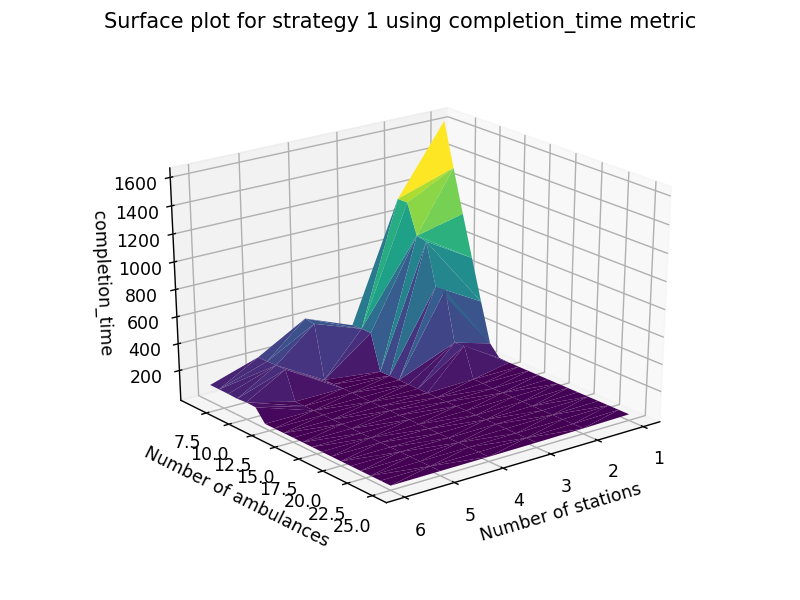

In [5]:
graph(1, "completion_time")

<IPython.core.display.Javascript object>


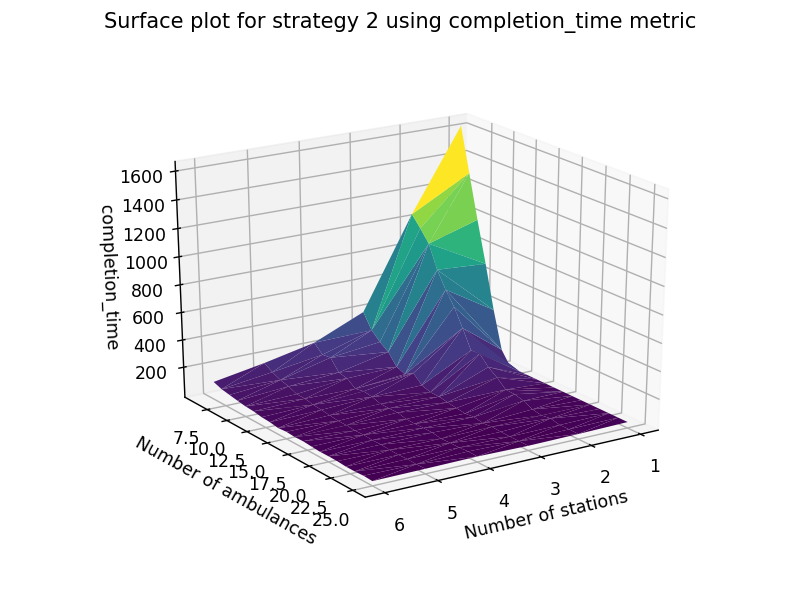

In [6]:
graph(2, "completion_time")

<IPython.core.display.Javascript object>


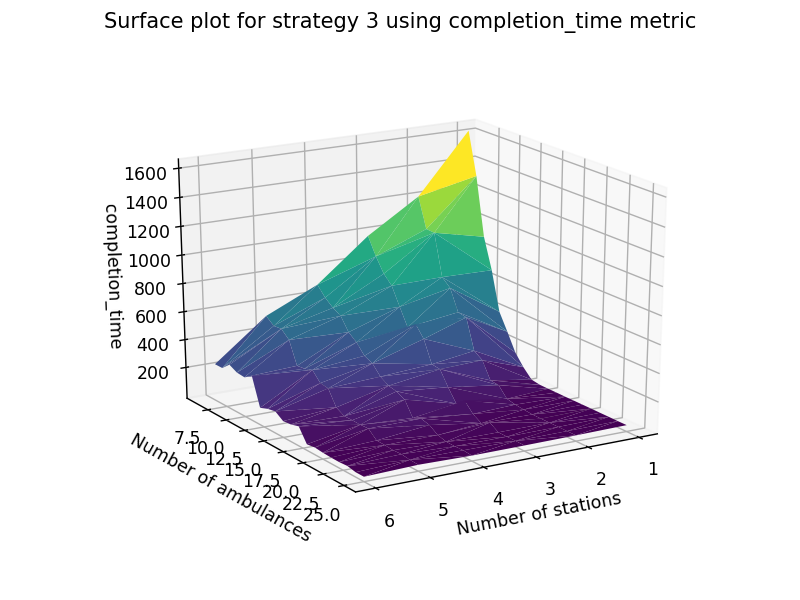

In [7]:
graph(3, "completion_time")

In [11]:
import networkx as nx
import random as rd
import matplotlib.pyplot as plt
import heapq as hq
import numpy as np
import functools
import pandas as pd
from collections import deque


map_hanoi = {
    "hoan_kiem": 1,
    "ba_dinh": 2,
    "cau_giay": 3,
    "hai_ba_trung": 4,
    "dong_da": 5,
    "tay_ho": 6,
    "gia_lam": 7
}

# Assume max probability is 0.8, lowest is 0.2
def calc_prob_call(density):
    prob_unit = (0.8 - 0.2)/(52000 - 2000)
    if density == 2000:
        return 0.2
    elif density == 52000:
        return 0.8
    else:
        return 0.2 + (density - 2000)*prob_unit

# Assume that density has a linear relationship with prob call
prob_call_map = {
    "hoan_kiem": calc_prob_call(36000),
    "ba_dinh": calc_prob_call(29000),
    "cau_giay": calc_prob_call(6000),
    "hai_ba_trung": calc_prob_call(52000),
    "dong_da": calc_prob_call(46000),
    "tay_ho": calc_prob_call(7000),
    "gia_lam": calc_prob_call(2000)
}

# Data taken from Google Maps estimation for cars
edge_hanoi = [
    (map_hanoi['hoan_kiem'], map_hanoi['ba_dinh'], 10),
    (map_hanoi['hoan_kiem'], map_hanoi['dong_da'], 15),
    (map_hanoi['hoan_kiem'], map_hanoi['hai_ba_trung'], 10),
    (map_hanoi['dong_da'], map_hanoi['cau_giay'], 8),
    (map_hanoi['dong_da'], map_hanoi['ba_dinh'], 8),
    (map_hanoi['dong_da'], map_hanoi['hai_ba_trung'], 15),
    (map_hanoi['cau_giay'], map_hanoi['tay_ho'], 10),
    (map_hanoi['ba_dinh'], map_hanoi['tay_ho'], 5),
    (map_hanoi['cau_giay'], map_hanoi['ba_dinh'], 15),
    (map_hanoi['ba_dinh'], map_hanoi['gia_lam'], 15),
    (map_hanoi['hoan_kiem'], map_hanoi['gia_lam'], 10),
]


class Map():
    def __init__(self, map=map_hanoi, edge=edge_hanoi, prop_call=prob_call_map):
        self.map = nx.Graph()
        self.map.add_nodes_from([(map_hanoi[k], {"prob_call": prop_call[k], "station": None}) for k in map_hanoi])
        self.map.add_weighted_edges_from(edge_hanoi)
        self.nodes_with_station = []


    def draw_map(self):
        nx.draw(self.map)
        plt.show()


    def generate_request(self):
        """Go through every location, roll random for requests"""
        for node in self.map.nodes:
            if rd.random() <= self.map.nodes[node]["prob_call"]:
                request = Request(at_node=node)
                self.send_to_nearest_station(request)


    def find_nearest_station(self, from_node):
        """ Find nearest node with a station from a node using BFS"""
        to_visit = deque([from_node])
        while to_visit:
            curr_node = to_visit.pop()
            # There is a chance that the call comes from a neighborhood with a station
            if self.map.nodes[curr_node]["station"]:
                return curr_node
            for node in list(self.map.neighbors(curr_node)):
                to_visit.appendleft(node)


    def send_to_nearest_station(self, request):
        """Send request to the nearest station"""
        station_node = self.find_nearest_station(request.location)
        self.map.nodes[station_node]["station"].take_request(request)


    def add_station_to(self, node, num_ambulances):
        """Add a station and ambulances to a node"""
        if not self.map.nodes[node]["station"]:
            self.map.nodes[node]["station"] = Station(map=self.map, at_node=node, num_ambulances=num_ambulances)
            self.nodes_with_station.append(node)


    def init_stations_amb_1(self, num_stations, total_ambulances):
        """
        Strategy 1: Initialize the stations and prioritize high-risk neighborhoods.
        Equally allocate ambulances to each station
        """
        # Sort the nodes according to risk probabilities
        sorted_risk = [(node, self.map.nodes[node]["prob_call"]) for node in list(self.map.nodes)]
        sorted_risk = sorted(sorted_risk, key=lambda x: x[1], reverse=True)

        # Add a station to each node, with appropriate # of ambulances
        for i in range(0, num_stations):
            self.add_station_to(sorted_risk[i][0], total_ambulances // num_stations)

        # Add any leftover ambulances to the first station (most risky location)
        first_station = self.map.nodes[sorted_risk[0][0]]["station"]
        first_station.ambulances += [0] * (total_ambulances % num_stations)

    
    def init_stations_amb_2(self, num_stations, total_ambulances):
        """
        Strategy 2: Same distribution of stations as Strat 1.
        Preferentially distribute total ambulances based on risk-profile
        """
        # Sort the nodes according to risk probabilities
        sorted_risk = [(node, self.map.nodes[node]["prob_call"]) for node in list(self.map.nodes)]
        sorted_risk = sorted(sorted_risk, key=lambda x: x[1], reverse=True)

        # Add a station to the nodes, set num of ambulances to 1
        # So each station has at least 1 ambulance first
        for i in range(0, num_stations):
            self.add_station_to(sorted_risk[i][0], 1)
        
        # Use the roulette-wheel probability method to pick stations
        cumsum_risk = np.cumsum([sorted_risk[i][1] for i in range(len(sorted_risk)) if i < num_stations])

        allocated_amb = num_stations
        while allocated_amb != total_ambulances:
            # searchsorted() returns an array, so we have to select the first element
            idx = cumsum_risk.searchsorted(np.random.uniform(0, cumsum_risk[-1], size=1))[0]
            curr_node = sorted_risk[idx][0]

            # Add an ambulance to the station
            self.map.nodes[curr_node]["station"].ambulances.append(0)
            allocated_amb += 1
    

    def init_stations_amb_3(self, num_stations, total_ambulances):
        """
        Strategy 3: Randomly distributes stations. Equally distribute ambulances
        """
        # Select random nodes to put stations in
        station_nodes = np.random.choice(list(self.map.nodes), num_stations, replace=False)
        for i in station_nodes:
            self.add_station_to(i, total_ambulances // num_stations)
        
        # Add any leftover ambulances to the most risky location
        most_risky_node = max([self.map.nodes[node] for node in station_nodes], key=lambda x: x["prob_call"])
        most_risky_node["station"].ambulances.extend([0] * (total_ambulances % num_stations))


    def use_stations(self):
        """Order all stations to dispatch ambulances"""
        for node in self.nodes_with_station:
            self.map.nodes[node]["station"].dispatch_ambulance()


    def decrement_all_ambulance_wait_time(self):
        """Decrement wait times for all stations"""
        for node in self.nodes_with_station:
            self.map.nodes[node]["station"].decrement_ambulance_wait_time()


    def increment_all_requests_wait_time(self):
        """Increment waiting times for all existing requests"""
        for node in self.nodes_with_station:
            self.map.nodes[node]["station"].increment_requests_wait_time() 


class Station():
    def __init__(self, map, at_node, num_ambulances):
        # Receive calls in a double-ended queue for O(1) updates
        self.requests = deque()
        # Use a heap to always choose the ambulance with the smallest waiting time
        # All ambulances in the beginning are idle
        self.ambulances = [0 for _ in range(num_ambulances)]
        hq.heapify(self.ambulances)
        self.location = at_node
        
        # First metric: request completion times
        self.request_wait_times = []

        # Second metric: outstanding number of requests
        self.outstanding_requests = []

        # Third metric: number of idle ambulances
        self.idle_ambulances = []
        self.map = map


    def take_request(self, request):
        self.requests.appendleft(request)


    def dispatch_ambulance(self):
        """Send ambulances out to serve requests"""
        def _sum_of_weights(path):
            """ Helper function to get path total weight"""
            sum = 0
            for i in range(len(path) - 1):
                sum += self.map.edges[(path[i], path[i+1])]["weight"]
            return sum

        # If there is at least 1 request
        if len(self.requests) >= 1:
            # If there are still idle ambulances
            while self.ambulances[0] == 0:
                # In the process of dispatching, if there are no more requests, break
                if len(self.requests) == 0:
                    break
                request = self.requests.pop()

                # If request location is the same as station location
                if request.location == self.location:
                    # Assume it takes no time to get to patient
                    # Only wait to treat patient
                    patient_wait_time = ambulance_wait_time = rd.randint(5, 10)
                else:
                    # Find shortest path given the weights
                    path = nx.shortest_path(self.map, self.location, request.location, weight="weight")
                    patient_wait_time = _sum_of_weights(path) + rd.randint(5, 10)
                    ambulance_wait_time = patient_wait_time + _sum_of_weights(path)

                # Update ambulance waiting time
                hq.heappushpop(self.ambulances, ambulance_wait_time)

                # Update time patients have to wait
                # The maximum between the time it takes for the ambulance to arrive and
                # the time the caller had to wait for the ambulance arrive
                self.request_wait_times.append(max(patient_wait_time, request.wait_time))

        # At the end of each dispatch, record how many calls are left on queue
        self.outstanding_requests.append(len(self.requests))

        # At the end of each dispatch, record how many idle ambulances there are
        self.idle_ambulances.append(len([a for a in self.ambulances if a == 0]))


    def decrement_ambulance_wait_time(self):
        """
        Decrease waiting times of all operating vehicles by 1
        """
        def decrement(wait_time):
            return wait_time - 1 if wait_time > 0 else wait_time

        self.ambulances = list(map(decrement, self.ambulances))
        hq.heapify(self.ambulances)
    

    def increment_requests_wait_time(self):
        """Increment wait time for all unserved calls"""
        for req in self.requests:
            req.increment_wait_time()


class Request():
    def __init__(self, at_node):
        self.location = at_node
        self.wait_time = 0

    def increment_wait_time(self):
        self.wait_time += 1


class Simulation():
    def __init__(self, stations, ambulances):
        self.map = Map()
        self.num_stations = stations
        self.num_ambulances = ambulances


    def use_strategy(self, strat_num):
        """Select a strategy to distribute stations and ambulances"""
        if strat_num == 1:
            self.map.init_stations_amb_1(num_stations=self.num_stations, total_ambulances=self.num_ambulances)
        elif strat_num == 2:
            self.map.init_stations_amb_2(num_stations=self.num_stations, total_ambulances=self.num_ambulances)
        elif strat_num == 3:
            self.map.init_stations_amb_3(num_stations=self.num_stations, total_ambulances=self.num_ambulances)
    
        
    def run_sim(self, interval=10, steps=8000):
        """
        Run simulation for _ steps
        At every _ interval, generate new requests
        """
        for minute in range(steps):
            self.map.decrement_all_ambulance_wait_time()
            self.map.increment_all_requests_wait_time()
            if minute % interval == 0:
                self.map.generate_request()
            self.map.use_stations()


    def get_request_times(self, merge=False):
        """
        Returns (station node, waiting time from that node) by default
        If merge = True, return data as a list with only int elements
        """
        data = []
        for node in self.map.nodes_with_station:
            data.append((node, self.map.map.nodes[node]["station"].request_wait_times))
        
        if merge:
            return functools.reduce(lambda a, b: a + b[1], data, [])
        else:
            return data

    
    def get_outstanding_requests(self, merge=False):
        """
        Returns (station node, outstanding requests from that node) by default
        If merge = True, add all lists together, element wise
        """
        data = []
        for node in self.map.nodes_with_station:
            data.append((node, self.map.map.nodes[node]["station"].outstanding_requests))
        
        if merge:
            # Add data from all station nodes, element-wise
            return functools.reduce(lambda a, b: np.add(a, b[1]), data, [0]*len(data[0][1]))
        else:
            return data
    
    def get_idle_ambulances(self, merge=False):
        """
        Returns (station node, number of idle ambulances in that node) by default
        If merge = True, add all lists together, element wise
        """
        data = []
        for node in self.map.nodes_with_station:
            data.append((node, self.map.map.nodes[node]["station"].idle_ambulances))
        
        if merge:
            # Add data from all station nodes, element-wise
            return functools.reduce(lambda a, b: np.add(a, b[1]), data, [0]*len(data[0][1]))
        else:
            return data  
        
    
    def hist_general(self, metric):
        """
        Generate a histogram for a metric.
        Combines metric data from all stations.
        """
        data = []
        if metric == "completion_time":
            data = self.get_request_times(merge=True)
        elif metric == "outstanding_req":
            data = self.get_outstanding_requests(merge=True)
        elif metric == "idle_ambulances":
            data = self.get_idle_ambulances(merge=True)
        
        plt.hist(data)
        plt.title(f"Average {round(np.average(data), 2)}, Median {round(np.median(data), 2)}, 95% Interval {np.percentile(data, [2.5, 97.5])}")
        plt.show()

    
    def hist_per_station(self, metric):
        """
        Generate histograms for a metric.
        One histogram for each station.
        """
        data = []
        if metric == "completion_time":
            data = self.get_request_times(merge=False)
        elif metric == "outstanding_req":
            data = self.get_outstanding_requests(merge=False)
        elif metric == "idle_ambulances":
            data = self.get_idle_ambulances(merge=False)
        
        fig, axs = plt.subplots(1, len(data))
        fig.suptitle(f"Histograms for {metric}")
        for i in range(len(data)):
            axs[i].hist(data[i][1])
            axs[i].set_title(f"Node {data[i][0]}, Avg: {round(np.average(data[i][1]), 2)}")
        plt.show()
        

def run_sim_strat(strat_num, stations, ambulances, metric, interval=10, steps=20000, plot_general=False, plot_each=False):
    """
    Run the simulation for a specific strategy, # stations, # ambulances.
    Set a metric to plot. Either plot aggregate data for the map or for each station.
    """
    sim = Simulation(stations=stations, ambulances=ambulances)
    sim.use_strategy(strat_num)
    sim.run_sim(interval=interval, steps=steps)

    # Plotting
    if plot_each:
        sim.hist_per_station(metric=metric)
    if plot_general:
        sim.hist_general(metric=metric)

    if metric == "completion_time":
        return np.average(sim.get_request_times(merge=True))
    elif metric == "outstanding_req":
        return np.average(sim.get_outstanding_requests(merge=True))
    elif metric == "idle_ambulances":
        return np.average(sim.get_idle_ambulances(merge=True))


def monte_carlo_avg_distribution(trials, strategy, stations, ambulances, metric, cumulative=False, density=False):
    """
    MC Simulation for a specific set of parameters: strategy, num stations, num ambulances, metric.
    Returns a distribution of the averages of the chosen metric.
    """
    mc_data = []
    for i in range(trials):
        sim_results = run_sim_strat(strat_num=strategy, stations=stations, ambulances=ambulances, metric=metric)
        mc_data.append(sim_results)
    plt.hist(mc_data, cumulative=cumulative, density=density, histtype="bar")
    plt.title(f"Strategy {strategy}, {metric} metric, Average {round(np.average(mc_data), 2)}, Median {round(np.median(mc_data), 2)}, 95% Interval {np.percentile(mc_data, [2.5, 97.5])}")
    plt.show()


def strat_compare(trials, stations, metric):
    """
    Plot a graph that compares all three strategies with increasing number of ambulances for the same number of stations
    """
    data = {}
    for strat in range(1, 4):
        data[strat] = []
        print("Strategy", strat)
        for amb in range(10, 21):
            mc_data = []
            print("# Ambulances", amb)
            for i in range(trials):
                print(i)
                sim_results = run_sim_strat(strat_num=strat, stations=stations, ambulances=amb, metric=metric)
                mc_data.append(sim_results)

            data[strat].append(np.average(mc_data))

    for strat in data:
        # The colors are randomized each time the function runs to
        # accommodate for increasing number of lanes you want to plot.
        # The plot generated here will look different from the plot in the paper
        # color-wise, but the content should be the same.

        color = list(np.random.choice(range(256), size=3))
        color = list(map(lambda x: x/256, color))
        plt.plot(range(10, 21), data[strat], color=color, label = f"Strategy {strat}")

    plt.xlabel("Number of total ambulances in the city")
    plt.ylabel(f"Average {metric}")
    plt.title(f"Comparing strategy performance with a constant # of stations and a varying # of ambulances")
    plt.legend()
    plt.show()


def generate_mc_data(trials):
    """
    Generates data for every permutation of parameters and strategies.
    Takes very long (could be hours) to run a reasonable simulation.
    """
    # 3 strategies
    data = []
    for strat_num in range(1, 4):
        print("strat", strat_num)
        # Minimum of 1 station, maximum of 6 stations
        for num_stations in range(1, 7):
            print("stations", num_stations)
            # Minimum of 6 ambulances, maximum of 25 ambulances
            for num_ambulances in range(6, 26):
                print("ambulances", num_ambulances)
                # For 3 different metrics
                # Storage for 3 metrics, in the order as shown below
                data_metric = []
                for metric in ["completion_time", "outstanding_req", "idle_ambulances"]:
                    mc_data = []
                    for i in range(trials):
                        sim_results = run_sim_strat(strat_num=strat_num, stations=num_stations, ambulances=num_ambulances, metric=metric, steps=7000)
                        mc_data.append(sim_results)
                    data_metric.append(np.average(mc_data))
                data.append([strat_num, num_stations, num_ambulances] + data_metric)
    df = pd.DataFrame({
        "strategy": [row[0] for row in data],
        "stations": [row[1] for row in data],
        "total_ambulances": [row[2] for row in data],
        "completion_time": [row[3] for row in data],
        "outstanding_req": [row[4] for row in data],
        "idle_ambulances": [row[5] for row in data]
    })
    df.to_csv("mc_data.csv")

    
# This was used to generate "mc_data.csv"
# generate_mc_data(100)

In [9]:
# How to run a single simulation with a set of parameters.
run_sim_strat(strat_num=1, stations=4, ambulances=12, steps=8000, plot_general=False, plot_each=False, metric="completion_time")

9.392776523702032

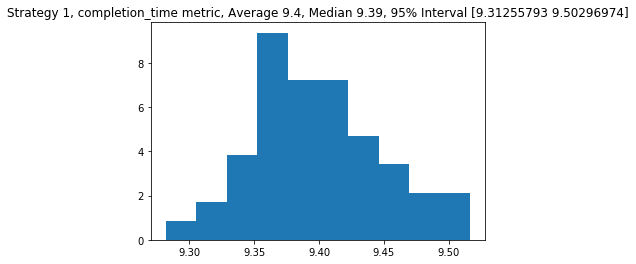

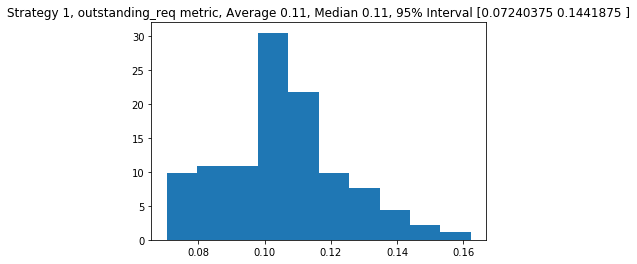

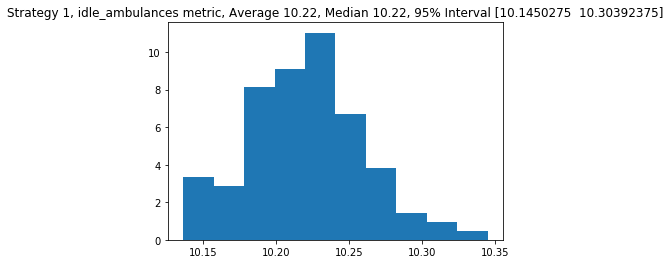

In [10]:
monte_carlo_avg_distribution(trials=100, strategy=1, stations=4, ambulances=14, metric="completion_time", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=1, stations=4, ambulances=14, metric="outstanding_req", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=1, stations=4, ambulances=14, metric="idle_ambulances", cumulative=False, density=True)

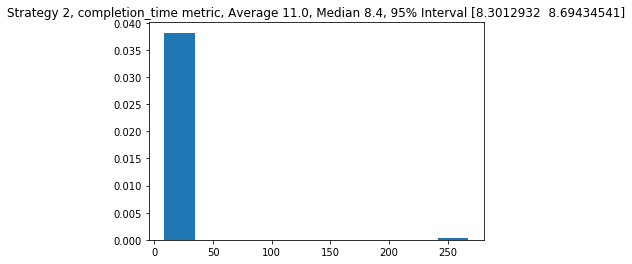

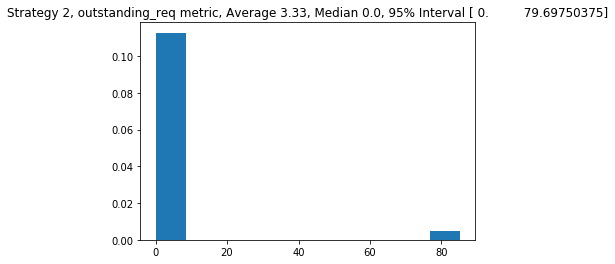

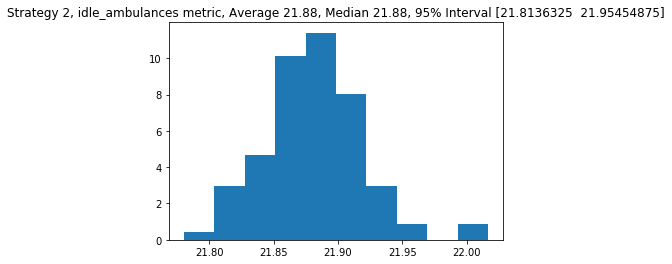

In [12]:
monte_carlo_avg_distribution(trials=100, strategy=2, stations=6, ambulances=25, metric="completion_time", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=2, stations=6, ambulances=25, metric="outstanding_req", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=2, stations=6, ambulances=25, metric="idle_ambulances", cumulative=False, density=True)

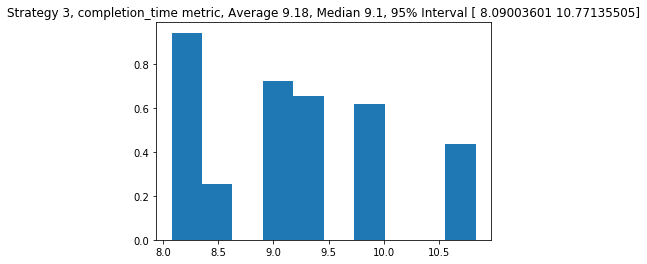

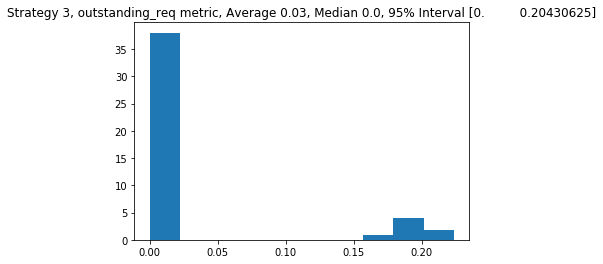

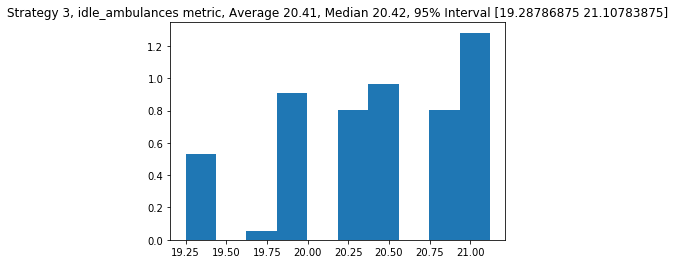

In [13]:
monte_carlo_avg_distribution(trials=100, strategy=3, stations=6, ambulances=24, metric="completion_time", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=3, stations=6, ambulances=24, metric="outstanding_req", cumulative=False, density=True)
monte_carlo_avg_distribution(trials=100, strategy=3, stations=6, ambulances=24, metric="idle_ambulances", cumulative=False, density=True)